# Area for testing Code

### Try code loading weather from weather station
This is updated code from a custom scraper

In [3]:
import requests
import csv
import lxml.html as lh
import datetime
from datetime import date

from util.UnitConverter import ConvertToSystem
from util.Parser import Parser
from util.Utils import Utils


def scrap_station(weather_station_url="https://www.wunderground.com/dashboard/pws/IDRSING3", 
                  unit_system="metric", start_DATE="", end_DATE="", timeout = 5, savepath="", output=True):
    """Get data from Weather Station. 
    Input: Parameters about station and start and end date
    Return: Pandas Dataframe in format for Weather Station"""
    
    session = requests.Session()
    
    url_gen = Utils.date_url_generator(weather_station_url, start_DATE, end_DATE)
    station_name = weather_station_url.split('/')[-1]
    if len(savepath)==0:
        savepath = f'{station_name}.csv'

    with open(savepath, 'a+', newline='') as csvfile:
        dfs = [] # Where the output will be saved to
        for date_string, url in url_gen:
            try:
                if output:
                    print(f'Downloading Weather data from {url}')
                history_table = False
                while not history_table:
                    html_string = session.get(url, timeout=timeout)
                    doc = lh.fromstring(html_string.content)
                    history_table = doc.xpath('//*[@id="main-page-content"]/div/div/div/lib-history/div[2]/lib-history-table/div/div/div/table/tbody')
                    if not history_table:
                        if output:
                            print("Refreshing session.")
                        session = requests.Session()

                data_rows = Parser.parse_html_table(date_string, history_table)

                converter = ConvertToSystem(unit_system)
                data_to_write = converter.clean_and_convert(data_rows)
                dfs.append(pd.DataFrame(data_to_write))
                    
                print(f'Saving {len(data_to_write)} rows')
            except Exception as e:
                print(e)
        df=pd.concat(dfs)
        df["station"] = station_name
        return df
    
def to_normed_df(df):
    """Transform a scrapped wunderground dataframe to a normalized df"""  
    
    dct = {'Temperature': 'temp', 'Precip_Accum': 'total_rain', 'Precip_Rate': 'hour_rain',  'Humidity': 'humidity',
           'Wind': 'wind_direction',  'Speed': 'wind',  'Speed': 'wind',  'Gust': 'wind_gust',
            'Pressure': 'pressure',  'Solar': 'solar', 'Dew_Point': 'dewpoint'
           }
    df_new = df.rename(columns=dct)
    
    ### Update data column as combo of date and time
    df_new["date"] 	=  pd.to_datetime(df["Date"].str.replace("/","-") + " " +  df["Time"])
    return df_new

def check_valid_wunder_df(df):
    """Does a quick check whether dataframe is valid for 
    software here."""
    
    cols = ['temp', 'hour_rain', 'total_rain', 'date', 'humidity',
       'wind_direction', 'wind', 'wind_gust', 'pressure', 'solar', 'dewpoint',
       'station']
    columns = df.columns
    
    for c in cols:
        if c not in columns:
            raise RuntimeWarning(f"Column {c} is missing")

In [ ]:
%%time
### Test running the scrapper

d1 = date(2017, 7, 1)
d2 = date(2017, 7, 3)

df = scrap_station(start_DATE=d1, end_DATE=d2)

In [46]:
dft = to_normed_df(df)

In [47]:
check_valid_wunder_df(dft)

In [57]:
d1 = date(2017, 7, 31)
d1 + datetime.timedelta(days=1)

datetime.date(2017, 8, 1)

In [ ]:
date = datetime.date(df["Date"])
time = datetime.time(df["Time"])
combined = datetime.datetime.combine(date, time)

In [65]:
df.head(2)

,Date,Time,Temperature,Dew_Point,Humidity,Wind,Speed,Gust,Pressure,Precip_Rate,Precip_Accum,UV,Solar,station
0,2017/07/01,02:03 AM,17.28,12.78,75.0,West,0.00,0.00,1008.81,0.0,0.0,0.0,0.0,IDRSING3
1,2017/07/01,02:08 AM,17.50,12.39,72.0,West,2.57,3.54,1009.14,0.0,0.0,0.0,0.0,IDRSING3


In [66]:
to_normed_df(df).head(2)

,Date,Time,temp,dewpoint,humidity,wind_direction,wind,wind_gust,pressure,hour_rain,total_rain,UV,solar,station
0,2017/07/01,02:03 AM,17.28,12.78,75.0,West,0.00,0.00,1008.81,0.0,0.0,0.0,0.0,IDRSING3
1,2017/07/01,02:08 AM,17.50,12.39,72.0,West,2.57,3.54,1009.14,0.0,0.0,0.0,0.0,IDRSING3


In [59]:
df.columns.values

array(['Date', 'Time', 'Temperature', 'Dew_Point', 'Humidity', 'Wind',
       'Speed', 'Gust', 'Pressure', 'Precip_Rate', 'Precip_Accum', 'UV',
       'Solar'], dtype=object)

## Test Loading the Data

In [2]:
import pandas as pd

In [7]:
df = pd.read_csv("IDRSING3.csv")

In [3]:
df1 = pd.read_csv("./Data/2017/10.csv")

# Test Production Code

In [1]:
import matplotlib.pyplot as plt
import datetime
from visualize_data import Analyze_WD
from load_data import SummaryData, WeatherData2

In [3]:
wd = WeatherData2()
wd.output = True

df = wd.download_data_day(4, 5, 2022)

Downloading: Year: 2022 Month: 5 Day: 4 
list index out of range! probably caused by an empty row in the data
Saving 286 rows


### Test Loading of whole Month

In [ ]:
%%time

from load_data import WeatherData2

month = datetime.date(year=2022, month=7, day=3)
# Test the Class:
wd = WeatherData2()
wd.local_save_month(month)

NameError: name 'datetime' is not defined

### Test plotting of clean data

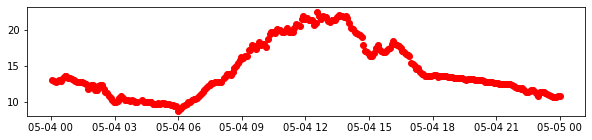

CPU times: user 425 ms, sys: 167 ms, total: 591 ms
Wall time: 319 ms


In [14]:
%%time

date = datetime.date(year=2022, month=5, day=4)
# Test the Class:
wd = WeatherData2()
wd.output = True

#df = wd.download_data_day(4, 5, 2022)
df = wd.give_data_day_clean(date)

plt.figure(figsize=(10,2))
plt.plot(df.index, df["temp"], 'ro')
plt.show()

#df.head(10)

In [ ]:
sd = SummaryData(wd)
v_wd = Analyze_WD(wd, sd)

month = datetime.date(year=2022, month=5, day=1)
v_wd.visualize_rain_month(date_month=month)

In [ ]:

sd = SummaryData(wd)
v_wd = Analyze_WD(wd, sd)

month = datetime.date(year=2018, month=6, day=1)
v_wd.visualize_rain_month(date_month=month)

In [3]:
wd = WeatherData2()
month = datetime.date(year=2022, month=5, day=1)
df = wd.give_data_month(month)

In [13]:
df.index

DatetimeIndex(['2022-04-30 22:04:00+00:00', '2022-04-30 22:09:00+00:00',
               '2022-04-30 22:14:00+00:00', '2022-04-30 22:19:00+00:00',
               '2022-04-30 22:24:00+00:00', '2022-04-30 22:29:00+00:00',
               '2022-04-30 22:34:00+00:00', '2022-04-30 22:39:00+00:00',
               '2022-04-30 22:44:00+00:00', '2022-04-30 22:49:00+00:00',
               ...
               '2022-05-31 21:14:00+00:00', '2022-05-31 21:19:00+00:00',
               '2022-05-31 21:24:00+00:00', '2022-05-31 21:29:00+00:00',
               '2022-05-31 21:34:00+00:00', '2022-05-31 21:39:00+00:00',
               '2022-05-31 21:44:00+00:00', '2022-05-31 21:49:00+00:00',
               '2022-05-31 21:54:00+00:00', '2022-05-31 21:59:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=8882, freq=None)

In [11]:
df.index.values.apply(lambda t: t.tz is None).all()

AttributeError: 'numpy.ndarray' object has no attribute 'apply'

In [ ]:
df.tz_localize('CET')

In [19]:
#.tz_convert(timezone = "Europe/Vienna") 

,Date,Time,temp,dewpoint,humidity,wind_direction,wind,wind_gust,pressure,hour_rain,total_rain,UV,solar,station
date,,,,,,,,,,,,,,
2022-04-30 22:04:00+00:00,2022/05/01,12:04 AM,7.00,0.67,64.0,SW,0.00,0.00,1021.00,0.0,0.0,0.0,0.0,IDRSING3
2022-04-30 22:09:00+00:00,2022/05/01,12:09 AM,6.83,0.22,63.0,SW,0.00,0.00,1021.00,0.0,0.0,0.0,0.0,IDRSING3
2022-04-30 22:14:00+00:00,2022/05/01,12:14 AM,6.67,-0.56,60.0,SW,0.00,0.00,1021.00,0.0,0.0,0.0,0.0,IDRSING3
2022-04-30 22:19:00+00:00,2022/05/01,12:19 AM,6.33,-1.44,57.0,SW,0.00,0.00,1021.00,0.0,0.0,0.0,0.0,IDRSING3
2022-04-30 22:24:00+00:00,2022/05/01,12:24 AM,6.50,-0.50,61.0,SW,0.00,0.00,1021.00,0.0,0.0,0.0,0.0,IDRSING3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31 21:39:00+00:00,2022/05/31,11:39 PM,17.50,8.00,54.0,ESE,0.80,1.77,1014.56,0.0,0.0,0.0,0.0,IDRSING3
2022-05-31 21:44:00+00:00,2022/05/31,11:44 PM,17.67,8.22,54.0,ESE,1.77,2.90,1014.56,0.0,0.0,0.0,0.0,IDRSING3
2022-05-31 21:49:00+00:00,2022/05/31,11:49 PM,17.72,8.28,54.0,SE,1.61,2.41,1014.90,0.0,0.0,0.0,0.0,IDRSING3


In [2]:
from dateutil.rrule import rrule, MONTHLY

In [28]:
d1 = date(2017, 7, 31)
d2 = date(2018, 12, 3)

In [29]:
for dt in rrule(MONTHLY, dtstart=d1, until=d2):
    print(dt)

2017-07-31 00:00:00
2017-08-31 00:00:00
2017-10-31 00:00:00
2017-12-31 00:00:00
2018-01-31 00:00:00
2018-03-31 00:00:00
2018-05-31 00:00:00
2018-07-31 00:00:00
2018-08-31 00:00:00
2018-10-31 00:00:00


In [15]:
import calendar



day=calendar.monthrange(d2.year, d2.month)[1]
x = datetime.datetime(d2.year, d2.month, day)
x

datetime.datetime(2017, 9, 30, 0, 0)

# Legacy

In [ ]:
def scrap_station(weather_station_url="https://www.wunderground.com/dashboard/pws/IDRSING3", 
                  unit_system="metric", start_DATE="", end_DATE="", timeout = 5, savepath="", output=True):
    """Get data from Weather Station. 
    Input: Parameters about station and start and end date
    Return: Pandas Dataframe in format for Weather Station"""
    
    session = requests.Session()
    
    url_gen = Utils.date_url_generator(weather_station_url, start_DATE, end_DATE)
    station_name = weather_station_url.split('/')[-1]
    if len(savepath)==0:
        savepath = f'{station_name}.csv'

    with open(savepath, 'a+', newline='') as csvfile:
        #fieldnames = ['Date', 'Time',	'Temperature',	'Dew_Point', 'Humidity', 'Wind', 'Speed',
        #              'Gust',	'Pressure',	'Precip_Rate',	'Precip_Accum',	'UV',   'Solar']
        #writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Write the correct headers to the CSV file
        # 12:04 AM	24.4 C	18.3 C	69 %	SW	0.0 km/h	0.0 km/h	1,013.88 hPa	0.00 mm	0.00 mm	0	0 w/m²
        
        #writer.writerow({'Date': 'Date', 'Time': 'Time', 
        #                 'Temperature': 'Temperature_C', 'Dew_Point':
        #                 'Dew_Point_C',	'Humidity': 'Humidity_%', 
        #                 'Wind': 'Wind', 'Speed': 'Speed_kmh',	
        #                 'Gust': 'Gust_kmh',	'Pressure': 'Pressure_hPa',	
        #                 'Precip_Rate': 'Precip_Rate_mm',	
        #                 'Precip_Accum': 'Precip_Accum_mm',	'UV': 'UV',   'Solar': 'Solar_w/m2'})
        
        dfs = [] # Where the output will be saved to
        for date_string, url in url_gen:
            try:
                if output:
                    print(f'Downloading Weather data from {url}')
                history_table = False
                while not history_table:
                    html_string = session.get(url, timeout=timeout)
                    doc = lh.fromstring(html_string.content)
                    history_table = doc.xpath('//*[@id="main-page-content"]/div/div/div/lib-history/div[2]/lib-history-table/div/div/div/table/tbody')
                    if not history_table:
                        if output:
                            print("Refreshing session.")
                        session = requests.Session()

                # parse html table rows
                data_rows = Parser.parse_html_table(date_string, history_table)

                # convert to metric system
                converter = ConvertToSystem(unit_system)
                data_to_write = converter.clean_and_convert(data_rows)
                dfs.append(pd.DataFrame(data_to_write))
                    
                print(f'Saving {len(data_to_write)} rows')
                #writer.writerows(data_to_write)
            except Exception as e:
                print(e)
        df=pd.concat(dfs)       
        return df